In [2]:
import numpy as np
from scipy.linalg import expm, solve_continuous_lyapunov, norm
from scipy.special import gamma
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt


## Matérn Covariance 

The parameters of the Matérn covariance matrix are the lengthscale $l$, the magnitude $\sigma^2$ and $\nu$ (or $p$). We start with $\nu=5/2$ (or $p=2$), and one variable. This means that $F$ is a 3 by 3 matrix of the form

$$F = \begin{bmatrix}0 & 1 & 0 \\ 0 & 0 & 1 \\ -\lambda^3 & -3\lambda^2 & -3\lambda \end{bmatrix} $$

 So, 

$$ \frac{dx(t)}{dt} = F x(t) + L dw(t) $$ 

where $x(t) = (f(t), f'(t), f''(t))$ and with spectral density $Q$. And so the discrete process is

$$x_{k+1} = A_k x_k + q_k, \; q_k \sim \mathcal{N}(0, \Sigma_k) $$

where
$$ A_k = A(\Delta t_k) = \exp (F \Delta t_k)) \\ \Sigma_k = \Sigma (\Delta t_k) = \int_0^{\Delta t_k} \exp(F(\Delta t_k - \tau)) L Q L^T \exp (F (\Delta t_k -\tau))^T d\tau $$

We use Matrix Decomposition to obtain 

$$ \Sigma (\Delta t_k) = C_\Sigma (\Delta t_k) D^{-1}_\Sigma (\Delta t_k) $$

where

$$ \begin{bmatrix} C_\Sigma (\Delta t) \\ D_\Sigma (\Delta t) \end{bmatrix} = \exp \left ( \begin{bmatrix} F & LQL^T \\ 0 & -F^T \end{bmatrix} \Delta t \right ) \begin{bmatrix} 0 \\ I_d \end{bmatrix}$$

Therefore, $D^{-1}_\Sigma (\Delta t_k) = A(\Delta t_k)^T$ and $C_\Sigma (\Delta t_k)$ is the upper right block matrix of the resulting matrix exponential.

There is an even simplier way to obtain $\Sigma (\Delta t_k)$, and that is via solving for $P$ in the following equation:

$$ FP + PF^T + L Q L^T = 0$$

which is the continuous Lyapunov equation. Once $P$ is obtained, then

$$ \Sigma (\Delta t) = P - A(\Delta t) P A(\Delta t)^T $$

In [8]:
class Matern52:
    def __init__(self, lengthscale, magnitude, dt, measurement_noise, observations):
        self.p = 2
        self.nu = 1/2 + self.p
        self.lengthscale = lengthscale
        self.magnitude = magnitude
        self.h = dt
        self.lamb = np.sqrt(2 * self.nu) / self.lengthscale

        self.q = ( 2 * self.magnitude**2 * np.pi**(1/2) * self.lamb**(2*self.p + 1) * gamma(self.p) ) / gamma(self.p + 1/2)

        self.F = np.array([[0, 1, 0],
                           [0, 0, 1],
                           [-self.lamb**3, -3*self.lamb**2, -3*self.lamb]])

        self.L = np.array([[0],
                           [0],
                           [1]])
    
        self.Q = self.q * np.eye(self.L.shape[1])

        self.Sig0 = solve_continuous_lyapunov(self.F, -self.L @ self.Q @ self.L.T)

        self.A = expm(self.F * self.h)
        self.Sigma = self.Sig0 - self.A @ self.Sig0 @ self.A.T

        self.H = np.array([1, 0, 0]).reshape(1,-1)

        self.output_dim = 1
        self.measurement_noise = measurement_noise
        self.R = np.eye(self.output_dim)

        self.observations = observations

        self.c_W = 1

    def _Sigma(self, dt: float) -> np.ndarray: #matrix decomposition approach

        G = np.block([[self.F, self.L @ self.Q @ self.L.T],
                    [np.zeros(self.F.shape), -self.F.T]]) #the 2n x 2n block matrix in matrix decomposition
        
        C = expm(G*dt)[:self.F.shape[0], self.F.shape[0]:] #upper right block of the matrix

        D_inv = self.A(self.F, dt).T #from above

        return C * D_inv
    
    def transition_dist(self, x_k : np.ndarray):
        return multivariate_normal(mean = x_k, cov=self.Sigma)

    def sample_path(self, tmax=50):

        x0 = multivariate_normal(np.zeros(self.p+1), self.Sig0).rvs()

        x = [x0]
        y = [self.H @ x0]

        for i in range(1, tmax):
            xi = self.transition_dist(x[i-1]).rvs()
            x.append(xi)

            yi = self.H @ xi
            y.append(yi)
            

    def IMQ(self, y, y_hat):
        return 1 / np.sqrt((1 + norm(y - y_hat)**2 / self.c_W**2))
    
    def fit(self):
        
        m = np.zeros((len(self.observations), self.p + 1)) #mean
        P = np.zeros((len(self.observations), self.p + 1, self.p + 1)) #covariance

        #Filter
        m[0] = np.zeros(self.p+1)
        P[0] = self.Sig0

        for k in range(0, len(self.observations) - 1):
            #predict
            m_prior = self.A @ m[k] # m_{k+1} = exp(F*dt) m_k
            P_prior = self.A @ P[k] @ self.A.T + self.Sigma # P_{k+1} = F P F^T + Sigma
            y_hat = self.H @ m_prior

            #update
            w_k = self.IMQ(self.observations[k+1], y_hat) #weights for robust Kalman Filter
            Residuals = self.observations[k+1] - self.H @ m_prior
            Innovation = self.H @ P_prior @ self.H.T + self.R * w_k**2 # here covariance R for the robust KF is now w**2 * R
            KalmanGain = P_prior @ self.H.T @ np.linalg.inv(Innovation)

            m[k+1] = m_prior + KalmanGain @ Residuals
            P[k+1] = P_prior - KalmanGain @ Innovation @ KalmanGain.T

        m_filt = m.copy()
        P_filt = P.copy()

        #Smoother
    
        for k in range(len(self.observations) - 2, -1, -1):
            m_prior = self.A @ m[k]
            P_prior = self.A @ P[k] @ self.A.T + self.Sigma

            C = P[k] @ self.A.T @ np.linalg.inv(P_prior)

            m[k] = m[k] + C @ (m[k+1] - m_prior)
            P[k] = P[k] + C @ (P[k+1] - P_prior) @ C.T
            
        return m_filt, P_filt, m, P

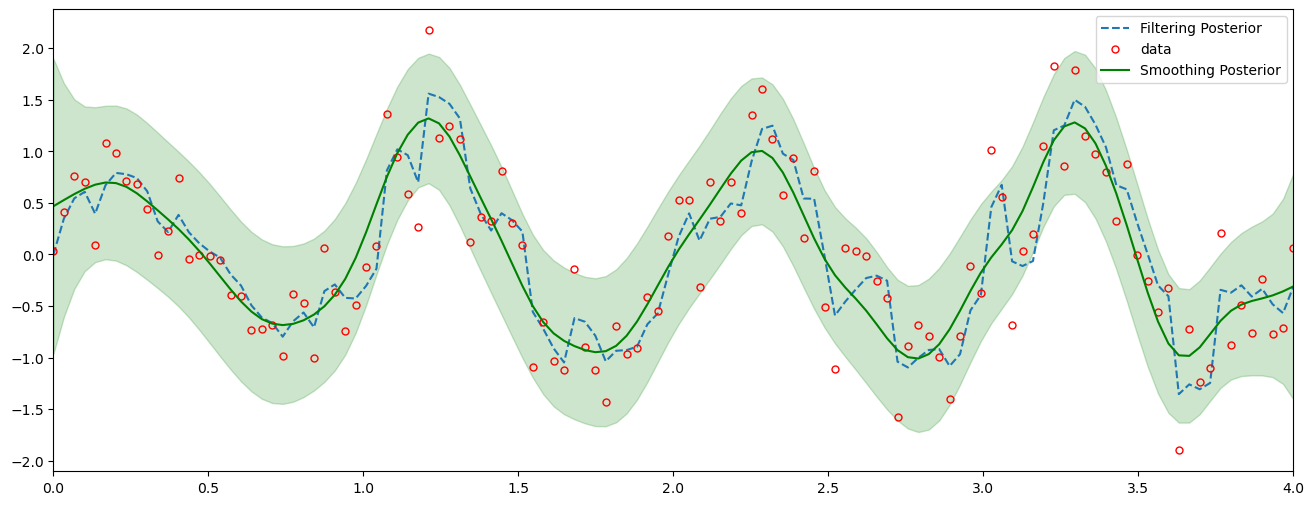

In [9]:
grid = np.linspace(0,4,120)
dt = grid[1]-grid[0]
obs = np.sin((2 * np.pi * grid)) + np.random.normal(loc=0, scale=0.5, size=len(grid))

matern = Matern52(0.3, 3, dt, 0.1, obs)

m_filt, P_filt, m, P = matern.fit()

plt.figure(figsize=(16,6))

plt.plot(grid, m_filt[:, 0], '--', label='Filtering Posterior')
plt.plot(grid, obs, 'o', markersize=5, color='red', fillstyle = 'none', label='data')
plt.plot(grid, m[:, 0], '-', color='green', label = 'Smoothing Posterior')
plt.fill_between(grid, m[:, 0] - 2 * np.sqrt(P[:, 0, 0]), m[:, 0] + 2 * np.sqrt(P[:, 0, 0]), alpha=0.2, color='green')
plt.xlim(grid[0], grid[-1])
plt.legend()
